<a href="https://colab.research.google.com/github/RomainCendre/DSTest/blob/main/deepsense_generative_takehome_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Data modeling

Given the following [data-set](https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json).



In [1]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res   = requests.get("https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json")
data  = np.array(res.json())

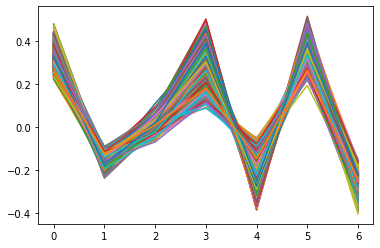

In [2]:
plt.plot(data.T);

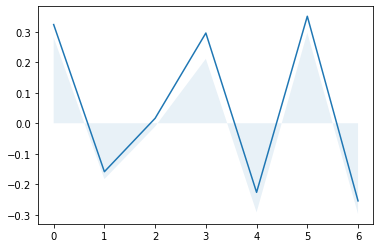

In [3]:
def mean_and_deviation(y):
    figure, axe = plt.subplots()
    x = range(y.shape[1])
    axe.plot(x, y.mean(axis=0))
    axe.fill_between(x, y.mean(axis=0) - y.std(axis=0), alpha=0.1)
    return figure
  
mean_and_deviation(data);

### 1. Can you generate 10k rows of new data from the same distribution?
Following considered data as (n_samples, n_features) shape like most library does.

Depend on the purpose but this has been a long topic to counter imbalanced data annotation during the training phase. Nowadays, such ideas are not used only to counter imbalanced data issues, but also in classification topics when the number of data is insufficient.

I will distinguish two main categories :
*   Generation based on linear functions, basically consist in generating new sample by interpolation of existing data points (1990-2010)
*   Generation based on deep learning, with generative models (last decade)

In [4]:
nb_samples = 1000; # 1000 for test

#### LINEAR
Here are used only standard ways to deals with synthetic sample based on linear solutions.


##### INTERPOLATION
Juste pick two random existing point and a random distance between both to generate new one sample.

In [5]:
from random import random, randint

def generate_interpolate(inputs, number):
  def interpolate(a, b, coeff):
    return a+(a-b)*coeff
  return np.array([interpolate(inputs[randint(0, len(inputs)-1)], inputs[randint(0, len(inputs)-1)], random()) for value in range(number)])

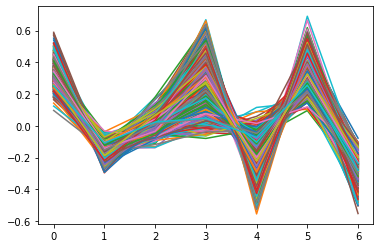

In [6]:
plt.plot(generate_interpolate(data, nb_samples).T);

##### PCA
In this solution, we used PCA as a way to constraint data to a lower space with only variance from existing sample (remaining encode information is considered as non useful and can be recover).

In [7]:
from sklearn.decomposition import PCA

def generate_pca(inputs, number, reduce_dim):
  pca = PCA(n_components=reduce_dim)
  pca.fit(data)  
  return np.array([pca.inverse_transform(random())[0] for value in range(number)])


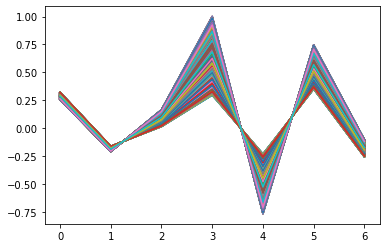

In [8]:
plt.plot(generate_pca(data, nb_samples, 1).T);

#### DEEP LEARNING
Here we considered deep learning to generate new synthetic data.

##### AUTO ENCODER
From the following blog article from keras : https://blog.keras.io/building-autoencoders-in-keras.html
Basic idea, in a same to PCA, is to use a bottleneck to constraint data to some features from wich we randomly recover new samples.

In [9]:
from keras import callbacks, optimizers
from keras.models import Model
from keras.layers import Input, Dense

class AutoEncoder:

  def __init__(self, latent_dim):    
      self.latent_dim = latent_dim
      self.optimizer  = optimizers.Adam()
      self.loss       = 'binary_crossentropy'

  def create_model(self, inputs):
      # Encoder
      input_ae      = Input(shape=(inputs.shape[1],))
      encoded       = Dense(inputs.shape[1]/2, activation='relu')(input_ae)
      encoded       = Dense(self.latent_dim, activation='relu')(encoded)
      self.encoder  = Model(input_ae, encoded)
      
      # Decoder 
      input_latent  = Input(shape=(self.latent_dim,))
      decoded       = Dense(inputs.shape[1]/2, activation='relu')(input_latent)
      decoded       = Dense(inputs.shape[1], activation='sigmoid')(decoded)
      self.decoder  = Model(input_latent, decoded)

      # Autoencoder 
      self.autoencoder = Model(input_ae, self.decoder(self.encoder(input_ae)))
      self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)
      
  def generate_samples(self, inputs, number):
    return self.decoder.predict(np.random.rand(number, 1))
      
  def train(self, inputs, epochs=50, batch_size=128):
      self.autoencoder.fit(inputs, inputs, epochs=epochs, batch_size=batch_size, 
                              shuffle=True, validation_split=0.1, 
                              callbacks=[ callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])


Epoch 1/50
11/11 [==============================] - 1s 46ms/step - loss: 0.6860 - val_loss: 0.6822
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6812 - val_loss: 0.6774
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6765 - val_loss: 0.6725
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6717 - val_loss: 0.6675
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6666 - val_loss: 0.6622
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6615 - val_loss: 0.6567
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6560 - val_loss: 0.6509
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6506 - val_loss: 0.6448
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6441 - val_loss: 0.6385
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6380 - val_loss: 0.6320
Epoch 11/50
11/11 

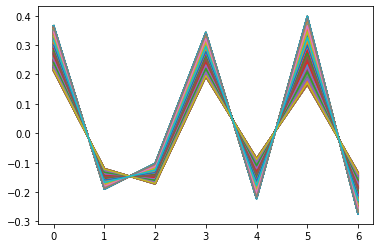

In [10]:
# Normalize data
ae_data = data+1/2

# Run AE
model = AutoEncoder(latent_dim = 1)
model.create_model(ae_data)
model.train(ae_data)

# Generate,denormalize and plot
ae_generate_data = model.generate_samples(data, nb_samples)
ae_generate_data = ae_generate_data*2-1
plt.plot(ae_generate_data.T);

##### VARIATIONAL AUTO ENCODER
From the following blog article from keras : https://blog.keras.io/building-autoencoders-in-keras.html

In [109]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Concatenate, Dense, Lambda, Input, concatenate, Flatten

class VariationalAutoEncoder:
  def __init__(self, latent_dim):
    self.latent_dim = latent_dim
    self.optimizer  = optimizers.Adam()
    self.loss       = 'binary_crossentropy'

  def create_model(self, inputs):
    # Encoder
    input_vae     = Input(shape=(inputs.shape[1],))
    encoded       = Dense(inputs.shape[1]/2, activation='relu')(input_vae)
    z_mean        = Dense(self.latent_dim)(encoded)
    z_log         = Dense(self.latent_dim)(encoded)
    encoded       = Lambda(VariationalAutoEncoder.sampling)([z_mean, z_log])
    self.encoder  = Model(input_vae, encoded)
    
    # Decoder 
    input_latent  = Input(shape=(self.latent_dim,))
    decoded       = Dense(inputs.shape[1]/2, activation='relu')(input_latent)
    decoded       = Dense(inputs.shape[1], activation='sigmoid')(decoded)
    self.decoder  = Model(input_latent, decoded)

    # Autoencoder 
    self.vautoencoder = Model(input_vae, self.decoder(self.encoder(input_vae)))
    self.vautoencoder.compile(optimizer=self.optimizer, loss=self.loss)
      
  def generate_samples(self, inputs, number):
    return self.decoder.predict(np.random.rand(number, 1))

  def sampling(args):
      z_mean, z_log = args
      epsilon = K.random_normal(shape=K.shape(z_mean),
                                mean=0., stddev=0.1)
      return z_mean + K.exp(z_log) * epsilon

  def train(self, inputs, epochs=200, batch_size=128):
      self.vautoencoder.fit(inputs, inputs, epochs=epochs, batch_size=batch_size, 
                              shuffle=True, validation_split=0.1, 
                              callbacks=[ callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])

Epoch 1/200
11/11 [==============================] - 1s 21ms/step - loss: 0.6912 - val_loss: 0.6878
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 0.6867 - val_loss: 0.6824
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6811 - val_loss: 0.6766
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 0.6752 - val_loss: 0.6700
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 0.6686 - val_loss: 0.6634
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6618 - val_loss: 0.6565
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6551 - val_loss: 0.6495
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6481 - val_loss: 0.6425
Epoch 9/200
11/11 [==============================] - 0s 6ms/step - loss: 0.6412 - val_loss: 0.6356
Epoch 10/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6345 - val_loss: 0.6289
Epoch 11

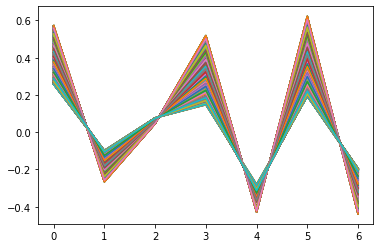

In [111]:
# Normalize data
vae_data = data+1/2

# Run VAE
model = VariationalAutoEncoder(latent_dim = 1)
model.create_model(vae_data)
model.train(vae_data)

# Generate, denormalize and plot
vae_generate_data = model.generate_samples(data, nb_samples)
vae_generate_data = vae_generate_data*2-1
plt.plot(vae_generate_data.T);

##### CONV AE
From the following blog article from keras : https://blog.keras.io/building-autoencoders-in-keras.html

In [112]:
from keras import callbacks, optimizers
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Cropping1D, MaxPooling1D, Reshape, UpSampling1D

class ConvAutoEncoder:

  def __init__(self, latent_dim):    
      self.latent_dim = latent_dim
      self.optimizer = optimizers.Adam()
      self.loss = 'binary_crossentropy'

  def create_model(self, inputs):
      # Encoder
      input_ae = Input(shape=(inputs.shape[1], 1))
      encoded = Conv1D(4, 3, activation='relu', padding='same')(input_ae)
      encoded = MaxPooling1D(2, padding='same')(encoded)
      encoded = Conv1D(2, 3, activation='relu', padding='same')(encoded)
      encoded = MaxPooling1D(2, padding='same')(encoded)
      encoded = Flatten()(encoded)
      encoded = Dense(self.latent_dim)(encoded)
      self.encoder = Model(input_ae, encoded)
      self.encoder.summary()
      
      # Decoder
      input_latent = Input(shape=(self.latent_dim,))
      decoded = Dense(4)(input_latent)
      decoded = Reshape((4, 1))(decoded)
      decoded = Conv1D(2, 3, activation='relu')(decoded)
      decoded = UpSampling1D(2)(decoded)
      decoded = Conv1D(4, 3, activation='relu', padding='same')(decoded)
      decoded = UpSampling1D(2)(decoded)
      decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(decoded)
      decoded = Cropping1D((1,0))(decoded)
      self.decoder = Model(input_latent, decoded)
      self.decoder.summary()

      # Autoencoder 
      self.autoencoder = Model(input_ae, self.decoder(self.encoder(input_ae)))
      self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)

  def train(self, inputs, epochs=200, batch_size=128):
      self.autoencoder.fit(inputs, inputs, epochs=epochs, batch_size=batch_size, 
                              shuffle=True, validation_split=0.1, 
                              callbacks=[ callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])
      
  def generate_samples(self, inputs, number):
    return self.decoder.predict(np.random.rand(number, 1))


Model: "model_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_104 (InputLayer)       [(None, 7, 1)]            0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 7, 4)              16        
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 4, 4)              0         
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 4, 2)              26        
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 2, 2)              0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 4)                 0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 5 

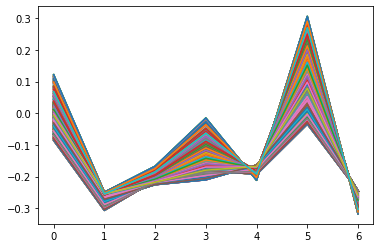

In [113]:
# Prepare data (normalized)
cae_data = np.expand_dims(data, 2)+1/2

# Run AE
model = ConvAutoEncoder(latent_dim = 1)
model.create_model(cae_data)
model.train(cae_data)

# Generate,denormalize and plot
cae_generate_data = model.generate_samples(data, nb_samples)
cae_generate_data = np.squeeze(cae_generate_data, 2)*2-1
plt.plot(cae_generate_data.T);

In [87]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_61 (UpSampling (None, 14, 14, 8)         0  

##### GAN
Inspired by https://github.com/eriklindernoren/Keras-GAN

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self, latent_dim=1):
      self.latent_dim = latent_dim 
      self.optimizer  = optimizers.Adam()
      self.loss       = 'binary_crossentropy'

    def create_model(self, inputs):
      # Discriminator        
      input_discriminator = Input(shape=(inputs.shape[1],))
      x                   = Dense(inputs.shape[1]/2, activation='relu')(input_discriminator)
      x                   = Dense(1, activation='sigmoid')(x) 
      self.discriminator  = Model(input_discriminator, x)
      self.discriminator.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])

      # Generator        
      input_generator     = Input(shape=(self.latent_dim,))
      x                   = Dense(inputs.shape[1]/2, activation='relu')(input_generator)
      x                   = Dense(inputs.shape[1], activation='sigmoid')(x) 
      self.generator      = Model(input_generator, x)

      # The generator takes noise as input and generates imgs
      z = Input(shape=(self.latent_dim,))
      img = self.generator(z)

      # For the combined model we will only train the generator
      self.discriminator.trainable = False

      # The discriminator takes generated images as input and determines validity
      validity = self.discriminator(img, inputs)

      # The combined model  (stacked generator and discriminator)
      # Trains the generator to fool the discriminator
      self.combined = Model(z, validity)
      self.combined.compile(loss=self.loss, optimizer=self.optimizer)

    def train(self, inputs, epochs=50, batch_size=128, sample_interval=50):

      # Adversarial ground truths
      valid = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))

      for epoch in range(epochs):

          # ---------------------
          #  Train Discriminator
          # ---------------------
          # Select a random batch of images
          idx = np.random.randint(0, inputs.shape[0], batch_size)
          imgs = inputs[idx]

          noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

          # Generate a batch of new images
          gen_imgs = self.generator.predict(noise)

          # Train the discriminator
          d_loss_real = self.discriminator.train_on_batch(imgs, valid)
          d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

          # ---------------------
          #  Train Generator
          # ---------------------
          noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

          # Train the generator (to have the discriminator label samples as valid)
          g_loss = self.combined.train_on_batch(noise, valid)

          # Plot the progress
          print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    def generate_samples(self, inputs, number):
            return self.generator.predict(np.random.rand(number, 1))


In [ ]:
# Normalize data
vae_data = data+1/2

# Run GAN
model = GAN(latent_dim = 1)
model.create_model(vae_data)
model.train(vae_data)

# Generate, denormalize and plot
vae_generate_data = model.generate_samples(data, nb_samples)
vae_generate_data = vae_generate_data*2-1
plt.plot(vae_generate_data.T);


### 2. How could prior-knowledge help you in this task?

In [ ]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res = requests.get("https://gist.githubusercontent.com/IdrissMg/695f423af0f0aaffd8d69bc403932c6b/raw/6f3192bbcc328f2aa53ae2faef0cefb825564ea9/data_science_test.json")
data = np.array(res.json())

In [ ]:
# The data-set is properly loaded
print(data[:10,:])